### Importing libraries

In [19]:
import pandas as pd
import nltk
import gensim
import numpy as np
import string
import pickle
import math 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.models import Model
from keras.models import load_model
from keras.initializers import Constant
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.preprocessing import image
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import pydot
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report


### Loading Amazon reviews for electronic products data

In [2]:
raw_data = pd.read_csv("part-amazon-reviews-unlocked-mobile-phones.csv") 
raw_data.drop(['Unnamed: 0'],axis=1,inplace=True)
raw_data.head(10)

,Rating,Reviews
0,5,I feel so LUCKY to have found this used (phone...
1,4,"nice phone, nice up grade from my pantach revu..."
2,5,Very pleased
3,4,It works good but it goes slow sometimes but i...
4,4,Great phone to replace my lost phone. The only...
5,1,I already had a phone with problems... I know ...
6,2,The charging port was loose. I got that solder...
7,2,"Phone looks good but wouldn't stay charged, ha..."
8,5,I originally was using the Samsung S2 Galaxy f...
9,3,It's battery life is great. It's very responsi...


In [3]:
sentences = raw_data['Reviews'].tolist()
sentences[0]

"I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!"

In [4]:
review_lines = list()
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wn.ADJ
    elif pos_tag.startswith('V'):
        return wn.VERB
    elif pos_tag.startswith('N'):
        return wn.NOUN
    elif pos_tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN
    
for line in sentences:
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words('english'))

    words = [w for w in words if not w in stop_words]


    # pos tag text
    pos_tags = pos_tag(words)
    # lemmatize text
    words = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    words = [t for t in words if len(t) > 1]
    review_lines.append(words)
    


In [6]:
count_tokens = 0
count_reviews = 0 
for sentences in review_lines:
    count_reviews += 1
    for word in sentences:
        count_tokens += 1
print("Number of reviews: ", count_reviews)
print("Number of tokens: ", count_tokens)

Number of reviews:  6000
Number of tokens:  150037


#### Storing preprocessed data

In [7]:
with open('amazon_products_preprocessed.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(review_lines, filehandle)

#### Loading the data

In [8]:
#with open('listfile.data', 'rb') as filehandle:
    # read the data as binary data stream
#    placesList = pickle.load(filehandle)

### Word2Vec, size = 150

In [9]:
modelw2v = gensim.models.Word2Vec(sentences = review_lines, size = 150, window = 5, workers=4, min_count=1)
words = list(modelw2v.wv.vocab)
print('Vocabulary size: ', len(words))
print(words)

Vocabulary size:  8738
['feel', 'lucky', 'find', 'use', 'phone', 'hard', 'line', 'someone', 'upgrade', 'sell', 'one', 'son', 'like', 'old', 'finally', 'fell', 'apart', 'year', 'nt', 'want', 'thank', 'seller', 'really', 'appreciate', 'honesty', 'say', 'phonei', 'recommend', 'highly', 'would', 'nice', 'grade', 'pantach', 'revue', 'clean', 'set', 'easy', 'never', 'android', 'fantastic', 'least', 'perfect', 'size', 'surf', 'social', 'medium', 'great', 'samsung', 'pleased', 'work', 'good', 'go', 'slow', 'sometimes', 'love', 'replace', 'lose', 'thing', 'volume', 'button', 'still', 'setting', 'adjust', 'job', 'eligible', 'againthaanks', 'already', 'problem', 'know', 'state', 'used', 'dang', 'charge', 'wish', 'read', 'comment', 'purchase', 'item', 'cracked', 'side', 'damage', 'try', 'another', 'way', 'request', 'money', 'back', 'get', 'sign', 'unhappy', 'customer', 'port', 'loose', 'solder', 'need', 'new', 'battery', 'well', 'later', 'include', 'cost', 'usable', 'look', 'stay', 'buy', 'could',

In [10]:
modelw2v.wv.most_similar('great')

[('condition', 0.9966838955879211),
 ('good', 0.9955444931983948),
 ('excellent', 0.9936575293540955),
 ('price', 0.9924485683441162),
 ('fast', 0.992112934589386),
 ('quality', 0.9920927286148071),
 ('sound', 0.9873008131980896),
 ('nice', 0.9862594604492188),
 ('visually', 0.9834963083267212),
 ('pretty', 0.9828264117240906)]

In [11]:
modelw2v.wv['great']

array([-2.92569637e-01, -2.73786575e-01,  3.17010105e-01,  2.55928338e-01,
        1.18911721e-01,  1.27243876e-01, -6.09113634e-01,  7.40808666e-01,
        1.39135018e-01, -1.27607569e-01, -9.65847135e-01, -6.04068637e-02,
       -1.65748522e-01,  5.14362276e-01, -2.83696502e-01,  2.25675344e-01,
        4.38331783e-01,  1.60328895e-01,  7.48975277e-01, -5.49162984e-01,
        1.54191002e-01,  7.66423285e-01, -1.85439572e-01,  1.59333557e-01,
        2.61708442e-02,  3.31607521e-01,  7.31864452e-01, -1.77273080e-01,
        3.65479708e-01,  3.58231455e-01,  2.30264291e-01, -5.93817294e-01,
        7.49516129e-01,  3.16912204e-01,  1.01200759e-01,  4.57693517e-01,
        1.45922557e-01, -1.89179078e-01,  6.65080369e-01, -7.61328638e-01,
       -1.96103826e-01, -2.65534669e-01, -6.50910795e-01, -3.15695912e-01,
        3.08418453e-01, -6.49899989e-02, -5.58305979e-01, -5.12571514e-01,
        1.95990965e-01, -6.16912544e-01,  5.75943850e-02,  1.85438573e-01,
        3.90944406e-02,  

In [13]:
filename = 'amazon_review_word2vec.txt'
modelw2v.wv.save_word2vec_format(filename,binary=False)

#### Loading the word embedding in a dictionary containing each word and its embedding

In [14]:
import os 

embeddings_index = {}
f = open(os.path.join('','amazon_review_word2vec.txt'),encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
    
f.close()

In [15]:
embeddings_index

{'8738': array(['150'], dtype='<U3'),
 'phone': array(['-0.20204921', '-0.38466364', '0.20023201', '0.16152704',
        '0.042363927', '0.10180681', '-0.37225965', '0.4681948',
        '0.108149804', '-0.033174805', '-0.9689852', '0.2272341',
        '-0.18115358', '0.5316418', '-0.2612876', '0.3077723', '0.5148611',
        '0.012987384', '0.620471', '-0.6014501', '-0.012252599',
        '0.47202095', '-0.28281912', '0.19528799', '0.14838761',
        '0.24826826', '0.6579451', '-0.013880979', '0.16816074',
        '0.29222906', '0.19219789', '-0.64212775', '0.67856574',
        '0.00046438474', '0.09470306', '0.6850231', '0.047336157',
        '-0.1141308', '0.6191465', '-0.95715517', '-0.30756217',
        '-0.068151794', '-0.4404097', '-0.19400316', '0.34370413',
        '0.019594323', '-0.48793855', '-0.5323383', '0.20453967',
        '-0.6460692', '0.21378984', '0.38597965', '-0.026200067',
        '0.38501787', '-0.26439646', '-0.2038041', '-0.66890043',
        '0.4547705', '-

#### Converting the words into tokenized, encoded vectors

In [16]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences = tokenizer_obj.texts_to_sequences(review_lines)

#fit_on_texts : Update internal vocabulary based on a list of texts. This method (fix_on_texts) creates 
# the vocabulary index based on word frequency (word --> index dictionary). Lower integer means more frequent word 
# 0 is reserved for padding

# texts_to_sequences : Transforms each text in texts to a sequence of integers. So it basically takes each 
# word in the text and replaces it with its corresponding integer value from the word_index dictionary.
print(review_lines[0])
print(sequences[0])

['feel', 'lucky', 'find', 'use', 'phone', 'use', 'hard', 'phone', 'line', 'someone', 'upgrade', 'sell', 'one', 'son', 'like', 'old', 'one', 'finally', 'fell', 'apart', 'year', 'nt', 'want', 'upgrade', 'thank', 'seller', 'really', 'appreciate', 'honesty', 'say', 'use', 'phonei', 'recommend', 'seller', 'highly', 'would']
[115, 1635, 78, 5, 1, 5, 229, 1, 346, 377, 289, 256, 10, 278, 9, 75, 10, 347, 884, 916, 112, 2, 44, 289, 176, 63, 22, 917, 2331, 33, 5, 812, 53, 63, 286, 12]


In [17]:
word_index = tokenizer_obj.word_index
print('Found %s tokens.' %len(word_index))
print(word_index)

Found 8738 tokens.
{'phone': 1, 'nt': 2, 'work': 3, 'good': 4, 'use': 5, 'great': 6, 'get': 7, 'screen': 8, 'like': 9, 'one': 10, 'buy': 11, 'would': 12, 'price': 13, 'well': 14, 'battery': 15, 'new': 16, 'iphone': 17, 'love': 18, 'come': 19, 'time': 20, 'camera': 21, 'really': 22, 'go': 23, 'card': 24, 'look': 25, 'sim': 26, 'take': 27, 'back': 28, 'product': 29, 'make': 30, 'even': 31, 'need': 32, 'say': 33, 'day': 34, 'charge': 35, 'also': 36, 'problem': 37, 'nice': 38, 'call': 39, 'purchase': 40, 'quality': 41, 'speaker': 42, 'could': 43, 'want': 44, 'much': 45, 'fast': 46, 'android': 47, 'apps': 48, 'thing': 49, 'receive': 50, 'review': 51, 'excellent': 52, 'recommend': 53, 'still': 54, 'issue': 55, 'feature': 56, 'money': 57, 'return': 58, 'month': 59, 'condition': 60, 'sound': 61, 'alcatel': 62, 'seller': 63, 'amazon': 64, 'try': 65, 'give': 66, 'first': 67, 'bad': 68, 'turn': 69, 'think': 70, 'case': 71, 'charger': 72, 'life': 73, 'seem': 74, 'old': 75, 'unlocked': 76, 'update'

In [20]:
review_sizes = []
max_long = 0
for i in range(len(review_lines)):
    review_sizes.append(len(review_lines[i]))
    max_long = max(max_long,len(review_lines[i]))   # Maximum vocabulary size in a review
    mean = sum(review_sizes)/len(review_sizes)
print("Mean of the length of reviews:",mean)
total_sum =0
for j in range(len(review_sizes)):
    total_sum += (review_sizes[j]-mean)**2
standard_deviation = math.sqrt(total_sum/len(review_sizes))
print("Standard deviation of the length of reviews:",standard_deviation)

Mean of the length of reviews: 25.006166666666665
Standard deviation of the length of reviews: 48.10811915507458


In [21]:
sequence_size = 30 # Number of words in a review 

In [22]:
review_pad = pad_sequences(sequences,maxlen=sequence_size)
rating = raw_data['Rating'].values
print(review_pad[0])
print('Shape of review tensor: ', review_pad.shape)
print('Shape of rating tensor: ', rating.shape)

[ 229    1  346  377  289  256   10  278    9   75   10  347  884  916
  112    2   44  289  176   63   22  917 2331   33    5  812   53   63
  286   12]
Shape of review tensor:  (6000, 30)
Shape of rating tensor:  (6000,)


### Now we can map embeddings from the loaded word2vec model for each word to the tokenizer_obj.word_index vocabulary and create a matrix with of word vectors.

In [23]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words,150))

for word, i in word_index.items():
    if i>num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
print(embedding_matrix.shape)

(8739, 150)


### The trained embedding vector is ready to be used directly in the embedding layer.

### Defining the model

In [25]:
model = Sequential()
embedding_layer = Embedding(num_words,
                           150,
                           embeddings_initializer = Constant(embedding_matrix),
                            input_length=sequence_size,
                           trainable = False)
model.add(embedding_layer)
model.add(Dense(2**9,input_dim=150,activation='relu',name='hidden1'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(2**6,activation='relu',name='hidden2'))
#model.add(Dropout(0.2))
model.add(Dense(5,activation='softmax',name='softmax'))
op = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 150)           1310850   
_________________________________________________________________
hidden1 (Dense)              (None, 30, 512)           77312     
_________________________________________________________________
flatten_1 (Flatten)          (None, 15360)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15360)             0         
_________________________________________________________________
hidden2 (Dense)              (None, 64)                983104    
_________________________________________________________________
softmax (Dense)              (None, 5)                 325       
Total params: 2,371,591
Trainable params: 1,060,741
Non-trainable params: 1,310,850
__________________________________________________________

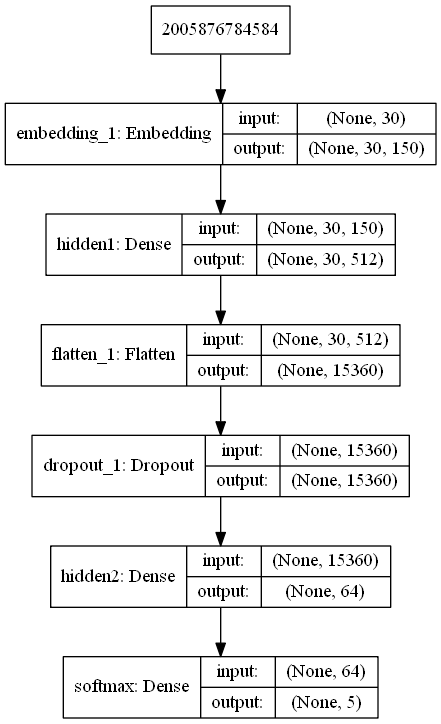

In [27]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='Model/model_MLP.png')
Image.open('Model/model_MLP.png')

#### Splitting the data

In [28]:
validation_split = 0.2
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
rating = rating[indices]
num_validation_samples = int(validation_split*review_pad.shape[0])

X_train_pad = review_pad[:-num_validation_samples]
y_train = rating[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = rating[-num_validation_samples:]
y_train_categ = np_utils.to_categorical(y_train-min(y_train))
y_test_categ = np_utils.to_categorical(y_test-min(y_test))
y_train

array([4, 1, 5, ..., 5, 5, 1], dtype=int64)

In [29]:
print('Shape of X_train_pad tensor: ', X_train_pad.shape)
print('Shape of X_test_pad tensor: ', X_test_pad.shape)
print('Shape of y_train_pad tensor: ', y_train.shape)
print('Shape of y_test_pad tensor: ', y_test.shape)

Shape of X_train_pad tensor:  (4800, 30)
Shape of X_test_pad tensor:  (1200, 30)
Shape of y_train_pad tensor:  (4800,)
Shape of y_test_pad tensor:  (1200,)


#### Saving training and test dataset

In [46]:
with open('X_train.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(X_train_pad, filehandle)
with open('y_train.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(y_train_categ, filehandle)  
with open('X_test.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(X_test_pad, filehandle)
with open('y_test.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(y_test, filehandle)   

#### Visualization of disturbing of the rates

C:\Users\begum\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


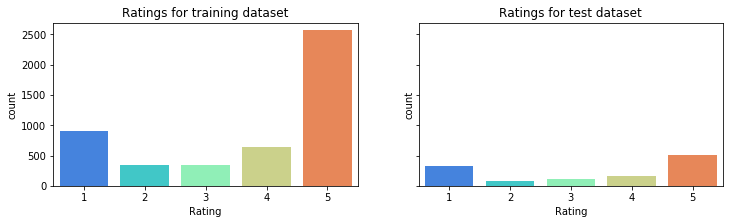

In [31]:
%matplotlib inline
fig, ax =plt.subplots(1,2,figsize=(12, 3), sharex=True, sharey=True)

sns.countplot(x='Rating',data=raw_data[:-num_validation_samples],palette='rainbow',ax=ax[0]).set_title('Ratings for training dataset')
sns.countplot(x='Rating',data=raw_data[-num_validation_samples:],palette='rainbow',ax=ax[1]).set_title('Ratings for test dataset')
fig.show()


In [32]:
history = model.fit(X_train_pad,y_train_categ,epochs=70,validation_data=(X_test_pad,y_test_categ),verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4800 samples, validate on 1200 samples
Epoch 1/70





 - 6s - loss: 1.2400 - acc: 0.5340 - val_loss: 1.2082 - val_acc: 0.5592
Epoch 2/70
 - 4s - loss: 1.1313 - acc: 0.5910 - val_loss: 1.1588 - val_acc: 0.5883
Epoch 3/70
 - 4s - loss: 1.1068 - acc: 0.5969 - val_loss: 1.1483 - val_acc: 0.5883
Epoch 4/70
 - 4s - loss: 1.0760 - acc: 0.6000 - val_loss: 1.1456 - val_acc: 0.5892
Epoch 5/70
 - 4s - loss: 1.0422 - acc: 0.6183 - val_loss: 1.1511 - val_acc: 0.5850
Epoch 6/70
 - 4s - loss: 1.0095 - acc: 0.6219 - val_loss: 1.1452 - val_acc: 0.5983
Epoch 7/70
 - 4s - loss: 0.9645 - acc: 0.6440 - val_loss: 1.1249 - val_acc: 0.6025
Epoch 8/70
 - 4s - loss: 0.9274 - acc: 0.6567 - val_loss: 1.1475 - val_acc: 0.6042
Epoch 9/70
 - 4s - loss: 0.8907 - acc: 0.6723 - val_loss: 1.1274 - val_acc: 0.6158
Epoch 10/70
 - 4s - loss: 0.8468 - acc: 0.6885 - val_loss: 1.1427 - val_acc: 0.6200
Epoch 11/70
 - 4s -

In [33]:
score = model.evaluate(X_test_pad,y_test_categ,verbose=1)

1200/1200 [==============================] - 0s 155us/step


In [ ]:
# With 256 neurons in the first hidden layer and 32 neurons in the second layer
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0],score[1]))

In [34]:
# With 512 neurons in the first hidden layer and 64 neurons in the second layer. Epoch is 70.
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0],score[1]))

Test score: 2.214, accuracy: 0.706


In [ ]:
# With 1024 neurons in the first layer and 64 neurons in the second layer. Epoch is 70. 
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0],score[1]))

#### I could not improve the accuracy by increasing epoch number and neuron numbers in two hidden layers. 

In [35]:
predictions = model.predict(X_test_pad)
print(confusion_matrix(y_test, np.argmax(predictions, axis=1)+np.min(y_test)))

[[183   7   7  16  40]
 [ 21  34   9   7  20]
 [  9   0  41   8  40]
 [  9   3   5  63  70]
 [ 32   0   4  46 526]]


In [36]:
print(classification_report(y_test,np.argmax(predictions, axis=1)+np.min(y_test)))

              precision    recall  f1-score   support

           1       0.72      0.72      0.72       253
           2       0.77      0.37      0.50        91
           3       0.62      0.42      0.50        98
           4       0.45      0.42      0.43       150
           5       0.76      0.87      0.81       608

    accuracy                           0.71      1200
   macro avg       0.66      0.56      0.59      1200
weighted avg       0.70      0.71      0.69      1200



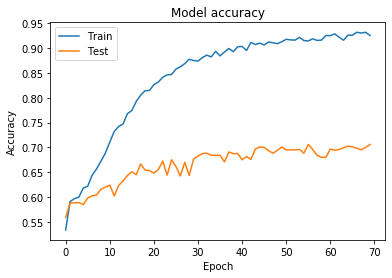

In [37]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

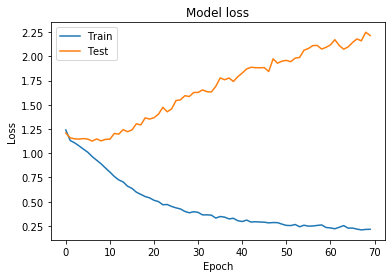

In [38]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Visualization for word vectors
#### I tried to see how  word2vec places similar words in space

In [39]:
keys = ['expensive','cheap','quality','good','handy','bad'] # The words that I chose randomly

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in modelw2v.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(modelw2v[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

C:\Users\begum\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
C:\Users\begum\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [40]:
embedding_clusters

[[array([-0.08473597, -0.19161375,  0.10900306,  0.08089108,  0.03420507,
          0.04654564, -0.20697598,  0.2580756 ,  0.06504248, -0.02350505,
         -0.5058428 ,  0.10992037, -0.11861875,  0.2625686 , -0.14550364,
          0.1658914 ,  0.24645075, -0.00555182,  0.30253673, -0.3067697 ,
         -0.02675141,  0.23303455, -0.14917478,  0.06594781,  0.08382361,
          0.10924611,  0.33770457,  0.005976  ,  0.0946541 ,  0.16549113,
          0.09649573, -0.30271184,  0.34771407,  0.01788663,  0.07147887,
          0.35106874,  0.02850279, -0.06833781,  0.2978286 , -0.47788438,
         -0.16103707, -0.03302698, -0.22403309, -0.11810596,  0.15902217,
          0.03352404, -0.23626521, -0.26266432,  0.08176774, -0.31375065,
          0.12753773,  0.20240332, -0.00435616,  0.19351485, -0.11206517,
         -0.10923036, -0.33306664,  0.22320494,  0.02141189,  0.16440561,
          0.14449733,  0.06505969, -0.13510525, -0.18867055, -0.01324588,
          0.21786347, -0.07116762, -0.

### t-SNE maps multi-dimensional data to two or more dimensions, where points which were initially far from each other are also located far away, and close points are also converted to close ones.

In [41]:
from sklearn.manifold import TSNE

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

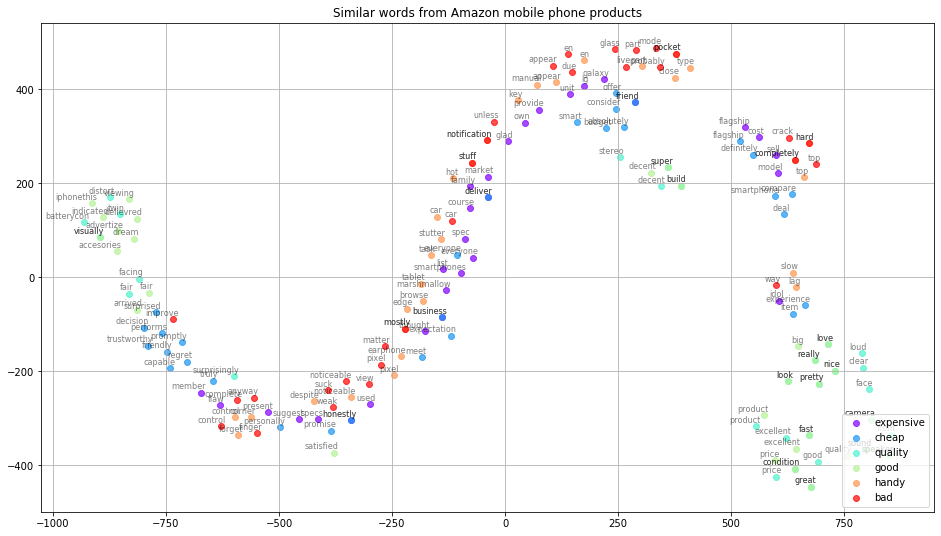

In [42]:
import matplotlib.cm as cm


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Amazon mobile phone products', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

#### Visualization word vectors in 3d

In [43]:
words_3d = []
embeddings_3d = []
for word in list(modelw2v.wv.vocab):
    embeddings_3d.append(modelw2v.wv[word])
    words_3d.append(word)
    
tsne_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_tsne_3d = tsne_3d.fit_transform(embeddings_3d)


C:\Users\begum\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


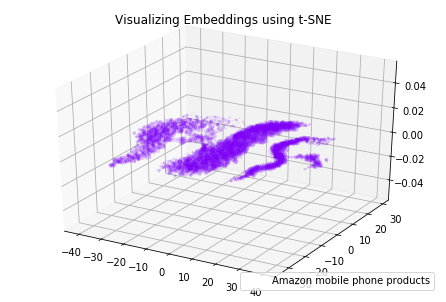

In [44]:
from mpl_toolkits.mplot3d import Axes3D


def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.show()


tsne_plot_3d('Visualizing Embeddings using t-SNE', 'Amazon mobile phone products', embeddings_tsne_3d, a=0.1)


### Word2vec, size = 300

In [ ]:
modelw2v_300 = gensim.models.Word2Vec(sentences = review_lines, size = 300, window = 5, workers=4, min_count=1)
words = list(modelw2v.wv.vocab)
print('Vocabulary size: ', len(words))
print(words)